In [1]:
from zipline import run_algorithm
from zipline.api import (
    order_target_percent,
    symbol,
    set_commission,
    set_benchmark,
    order,
    record
)
import numpy as np
from zipline.finance.commission import PerTrade
import pandas as pd
import pyfolio as pf
from pyfolio.utils import extract_rets_pos_txn_from_zipline
import warnings
import matplotlib.pyplot as plt
import talib
from talib import MACD # type: ignore
warnings.filterwarnings('ignore')
warnings.filterwarnings('always')

/home/shell007/anaconda3/envs/fa/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/shell007/anaconda3/envs/fa/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/shell007/anaconda3/envs/fa/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/shell007/anaconda3/envs/fa/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
%matplotlib inline 
%load_ext zipline

In [3]:
def initialize(context):
    context.asset = symbol('BTC')
    context.i = 0
    context.short_span = 1
    context.long_span = 7
    context.signal_span = 3

def handle_data(context, data):
    context.i += 1
    if context.i < context.long_span:
        return
    prices = data.history(context.asset, 'close', context.long_span, '1d')
    ema12 = prices.ewm(span= context.short_span, adjust= False).mean()
    ema26 = prices.ewm(span= context.long_span, adjust= False).mean()
    macd = ema12 - ema26
    signal = macd.ewm(span= context.signal_span, adjust= False).mean()
    hist = macd - signal
    if macd[-1] > signal[-1] and macd[-2] <= signal[-2]:
        order(context.asset, 100)
    elif macd[-1] < signal[-1] and macd[-2] >= signal[-2]:
        order(context.asset, -100)
    
    record(macd=macd[-1], signal=signal[-1], price=data.current(context.asset, 'price'))

In [4]:
start_date = pd.to_datetime('2021-12-12', utc= True, format = '%Y-%m-%d %H:%M')
end_date = pd.to_datetime('2022-8-8', utc= True, format = '%Y-%m-%d %H:%M')
# print(start_date)    
results = run_algorithm(start=start_date, end=end_date, initialize=initialize, capital_base=10000, handle_data=handle_data, data_frequency='daily', bundle='cryptocompare_daily')


/home/shell007/anaconda3/envs/fa/lib/python3.9/site-packages/empyrical/stats.py:706: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/home/shell007/anaconda3/envs/fa/lib/python3.9/site-packages/empyrical/stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/home/shell007/anaconda3/envs/fa/lib/python3.9/site-packages/empyrical/stats.py:706: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/home/shell007/anaconda3/envs/fa/lib/python3.9/site-packages/empyrical/stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/home/shell007/anaconda3/envs/fa/lib/python3.9/site-packages/empyrical/stats.py:706: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/home/shell007/anaconda3/envs/fa/lib/python3.9/site-packages/empyrical/stats.py:797: RuntimeWarning: invalid va

In [5]:
# results.describe()

In [6]:
# results.tail()

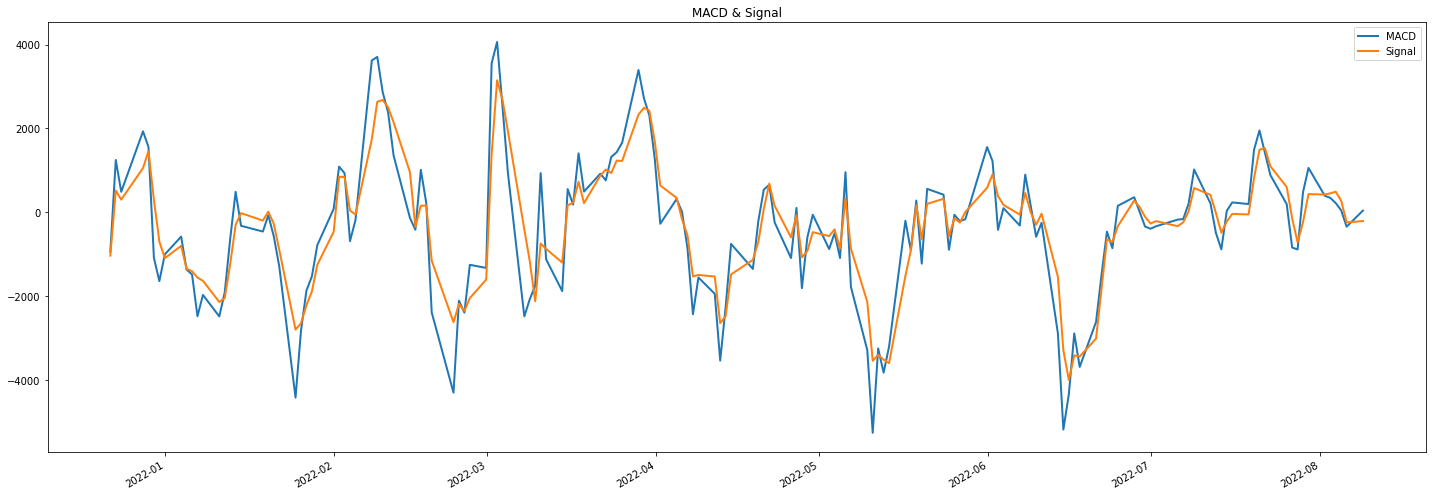

In [7]:
results.macd.plot(figsize=(20, 7), title='MACD & Signal' , lw=2, label='MACD')
results.signal.plot(figsize=(20, 7), lw=2, label='Signal')
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
returns, positions, transactions = extract_rets_pos_txn_from_zipline(results)

/home/shell007/anaconda3/envs/fa/lib/python3.9/site-packages/matplotlib/dates.py:446: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  d = d.astype('datetime64[us]')


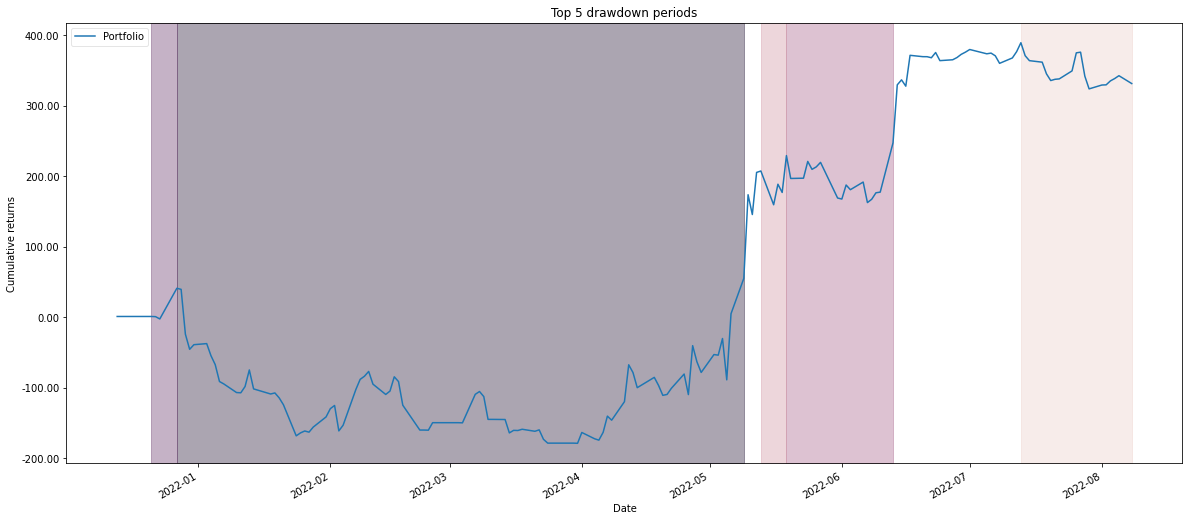

In [9]:
plt.figure(figsize=(20, 9))
pf.plot_drawdown_periods(returns, top=5).set_xlabel('Date')
plt.show()

/home/shell007/anaconda3/envs/fa/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/shell007/anaconda3/envs/fa/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/shell007/anaconda3/envs/fa/lib/python3.9/site-packages/pyfolio/timeseries.py:734: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/home/shell007/anaconda3/envs/fa/lib/python3.9/site-packages/empyrical/stats.py:1495: RuntimeWarning: invalid value encountered in log1p
  cum_log_returns = np.log1p(returns).cumsum()


Start date,2021-12-13
End date,2022-08-08
Total months,7
,Backtest
Annual return,706803.423%
Cumulative returns,33044.719%
Annual volatility,2596.84%
Sharpe ratio,-0.42
Calmar ratio,1317.77
Stability,NaN
Max drawdown,-536.363%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,536.36,2021-12-27,2022-03-31,2022-05-09,96
1,351.28,2021-12-21,2021-12-23,2021-12-27,5
2,29.08,2022-05-19,2022-06-07,2022-06-13,18
3,23.11,2022-05-13,2022-05-16,2022-05-19,5
4,16.82,2022-07-13,2022-07-29,NaT,NaN


/home/shell007/anaconda3/envs/fa/lib/python3.9/site-packages/pyfolio/plotting.py:835: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/home/shell007/anaconda3/envs/fa/lib/python3.9/site-packages/pyfolio/plotting.py:835: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/home/shell007/anaconda3/envs/fa/lib/python3.9/site-packages/pyfolio/plotting.py:835: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/home/shell007/anaconda3/envs/fa/lib/python3.9/site-packages/matplotlib/dates.py:446: DeprecationWarning: parsing timezone aware datetimes is deprecated; thi

Stress Events,mean,min,max
New Normal,-4.29%,-1731.87%,1017.34%


/home/shell007/anaconda3/envs/fa/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/shell007/anaconda3/envs/fa/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Top 10 long positions of all time,max
sid,
BTC,64756.83%


Top 10 short positions of all time,max
sid,
BTC,-38694.14%


Top 10 positions of all time,max
sid,
BTC,64756.83%


/home/shell007/anaconda3/envs/fa/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/shell007/anaconda3/envs/fa/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/shell007/anaconda3/envs/fa/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/shell007/anaconda3/envs/fa/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/shell007/anaconda3/envs/fa/lib/python3.9/site-packages/pyfolio/round_trips.py:331: FutureWarning: The frame.

Summary stats,All trades,Short trades,Long trades
Total number of round_trips,29.00,22.00,7.00
Percent profitable,0.59,0.68,0.29
Winning round_trips,17.00,15.00,2.00
Losing round_trips,12.00,7.00,5.00
Even round_trips,0.00,0.00,0.00


PnL stats,All trades,Short trades,Long trades
Total profit,$3304477.70,$4811417.45,$-1506939.76
Gross profit,$6701191.67,$5930483.95,$770707.72
Gross loss,$-3396713.98,$-1119066.50,$-2277647.48
Profit factor,$1.97,$5.30,$0.34
Avg. trade net profit,$113947.51,$218700.79,$-215277.11
Avg. winning trade,$394187.75,$395365.60,$385353.86
Avg. losing trade,$-283059.50,$-159866.64,$-455529.50
Ratio Avg. Win:Avg. Loss,$1.39,$2.47,$0.85
Largest winning trade,$1020069.54,$1020069.54,$666211.95
Largest losing trade,$-686412.92,$-393330.00,$-686412.92


Duration stats,All trades,Short trades,Long trades
Avg duration,11 days 07:35:10.379310344,10 days 20:54:32.772727272,12 days 17:08:34.285714285
Median duration,12 days 00:00:00,11 days 12:00:00,14 days 00:00:00
Longest duration,23 days 00:00:00,17 days 00:00:00,23 days 00:00:00
Shortest duration,1 days 00:00:00,2 days 00:00:00,1 days 00:00:00


Return stats,All trades,Short trades,Long trades
Avg returns all round_trips,6.87%,0.62%,30.63%
Avg returns winning,34.06%,22.56%,59.92%
Avg returns losing,-25.26%,-19.13%,-86.55%
Median returns all round_trips,1.29%,-0.93%,50.39%
Median returns winning,30.64%,25.72%,51.17%
Median returns losing,-11.50%,-11.29%,-86.55%
Largest winning trade,103.53%,70.04%,103.53%
Largest losing trade,-86.55%,-74.64%,-86.55%


Symbol stats,BTC
Avg returns all round_trips,6.87%
Avg returns winning,34.06%
Avg returns losing,-25.26%
Median returns all round_trips,1.29%
Median returns winning,30.64%
Median returns losing,-11.50%
Largest winning trade,103.53%
Largest losing trade,-86.55%


Profitability (PnL / PnL total) per name,
symbol,
BTC,100.00%


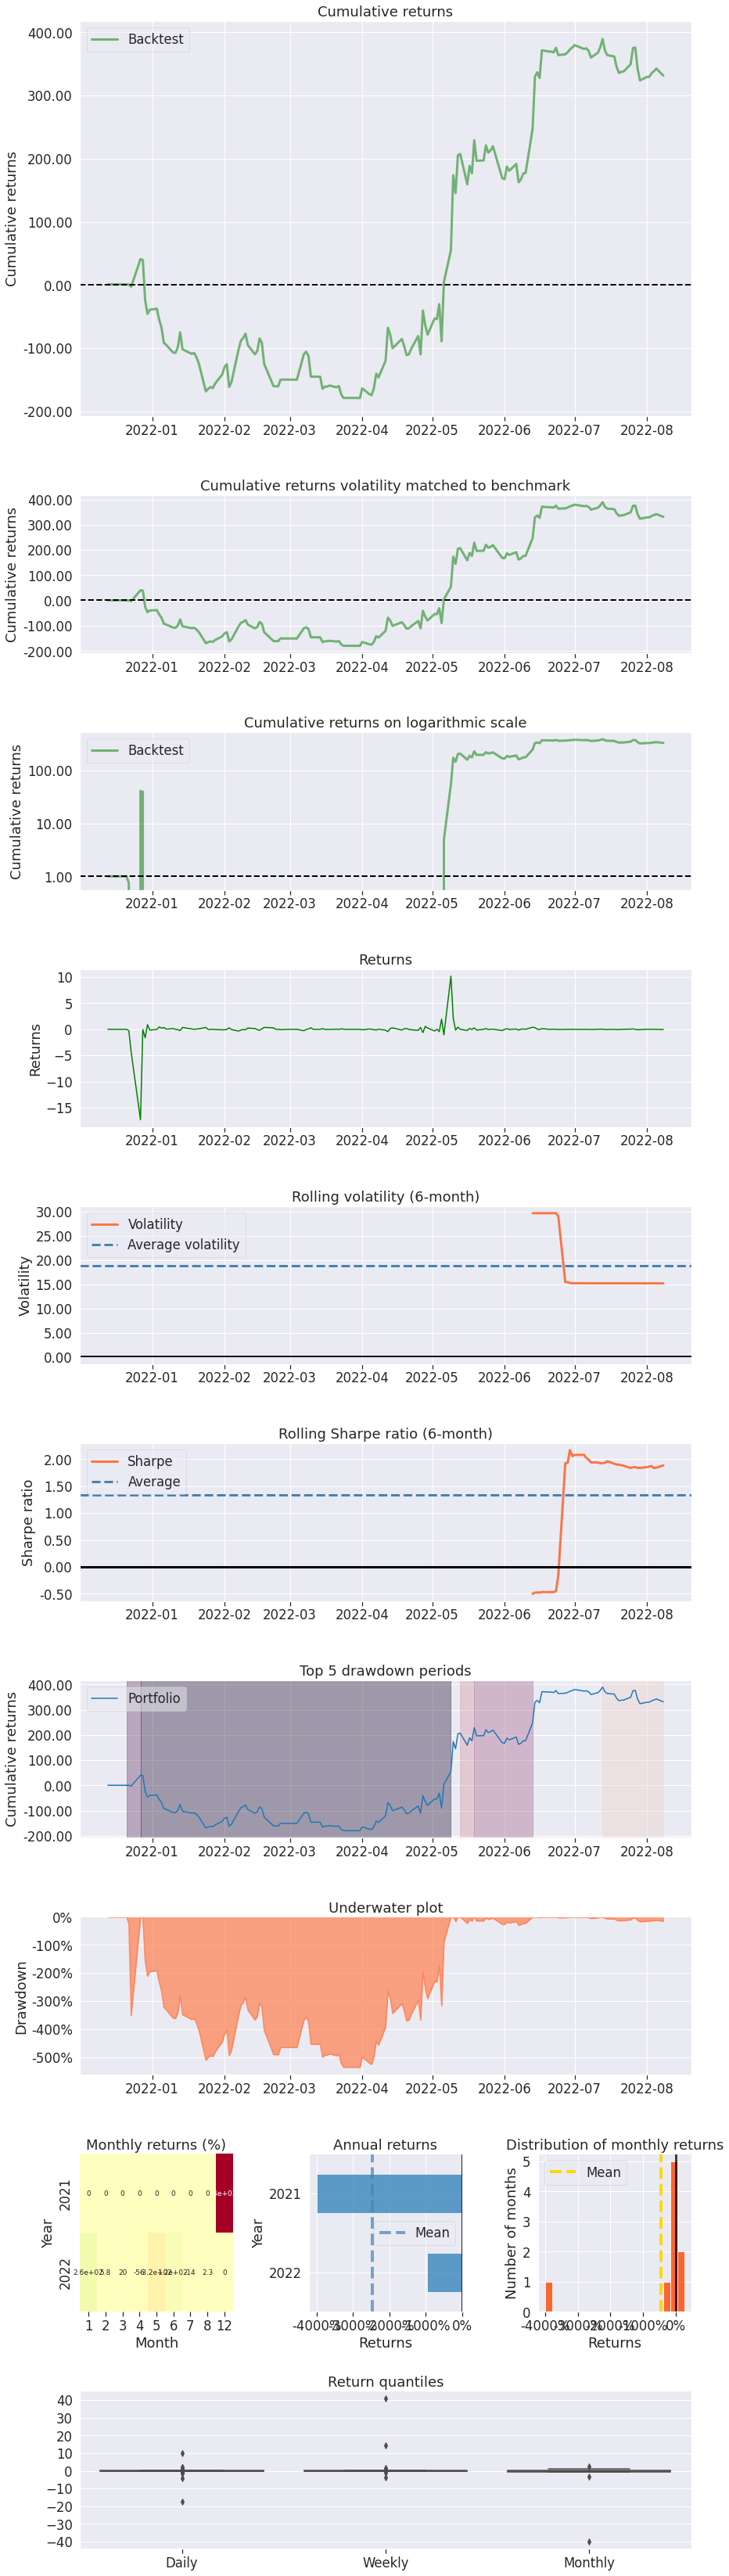

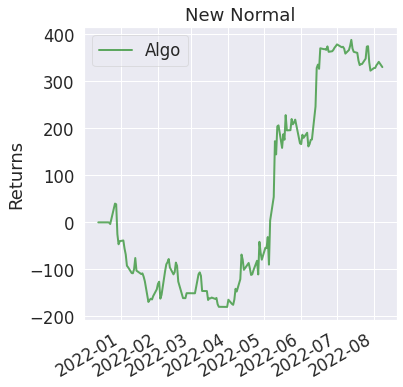

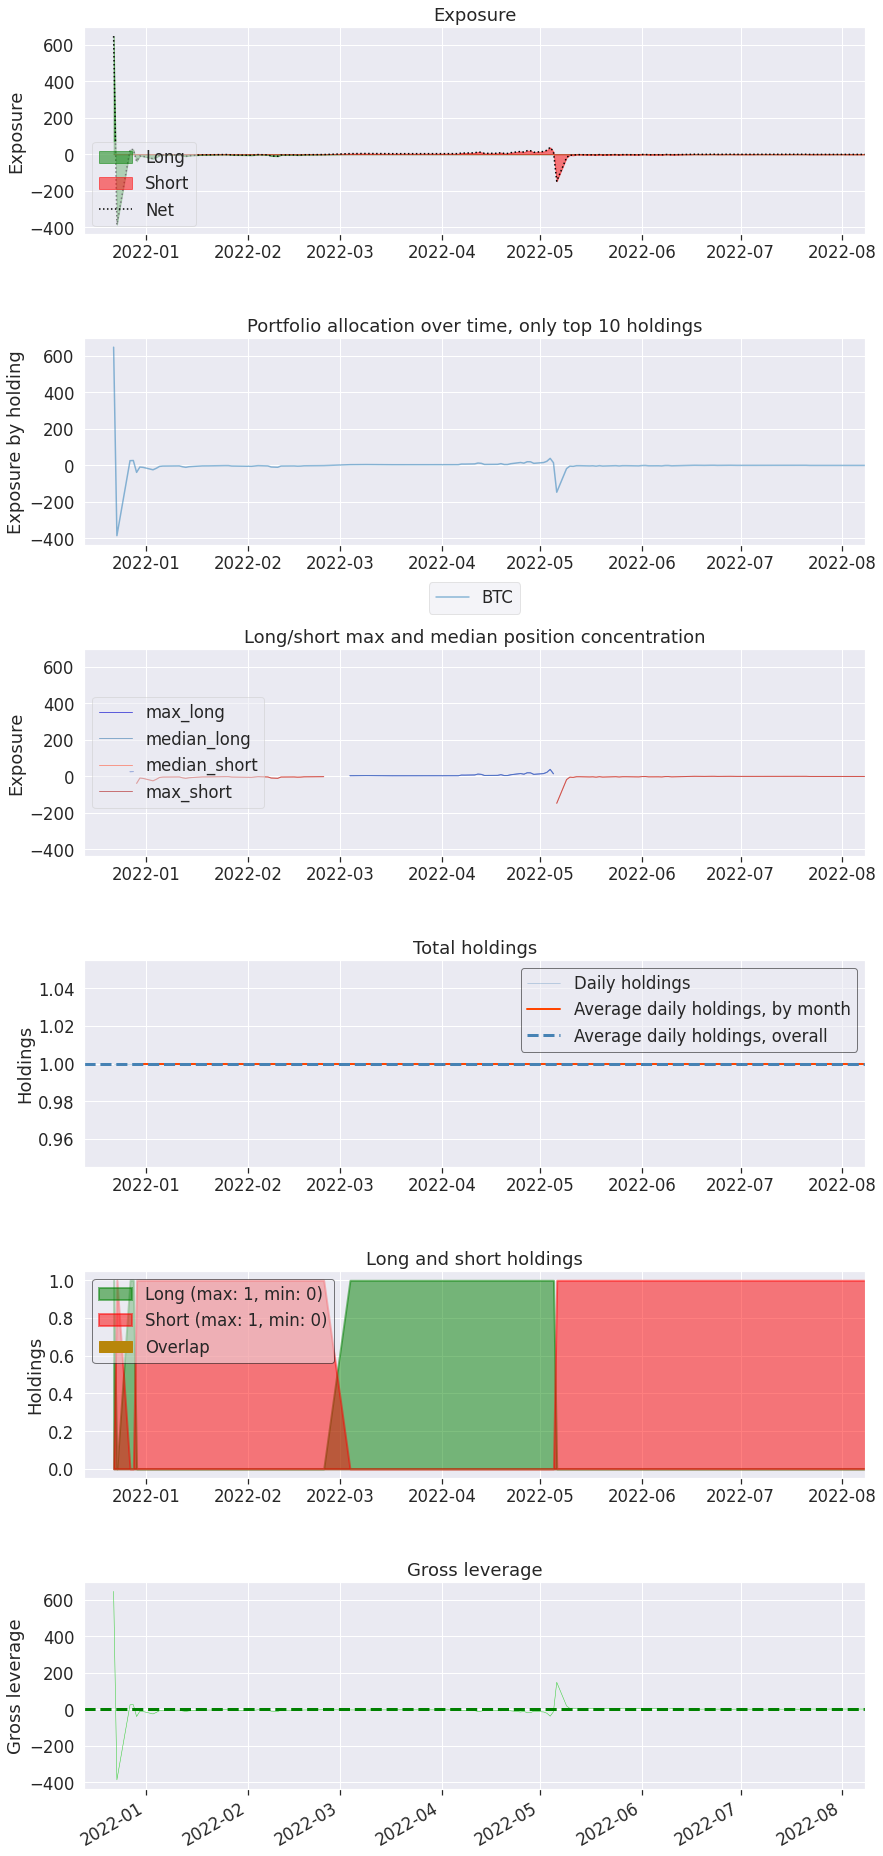

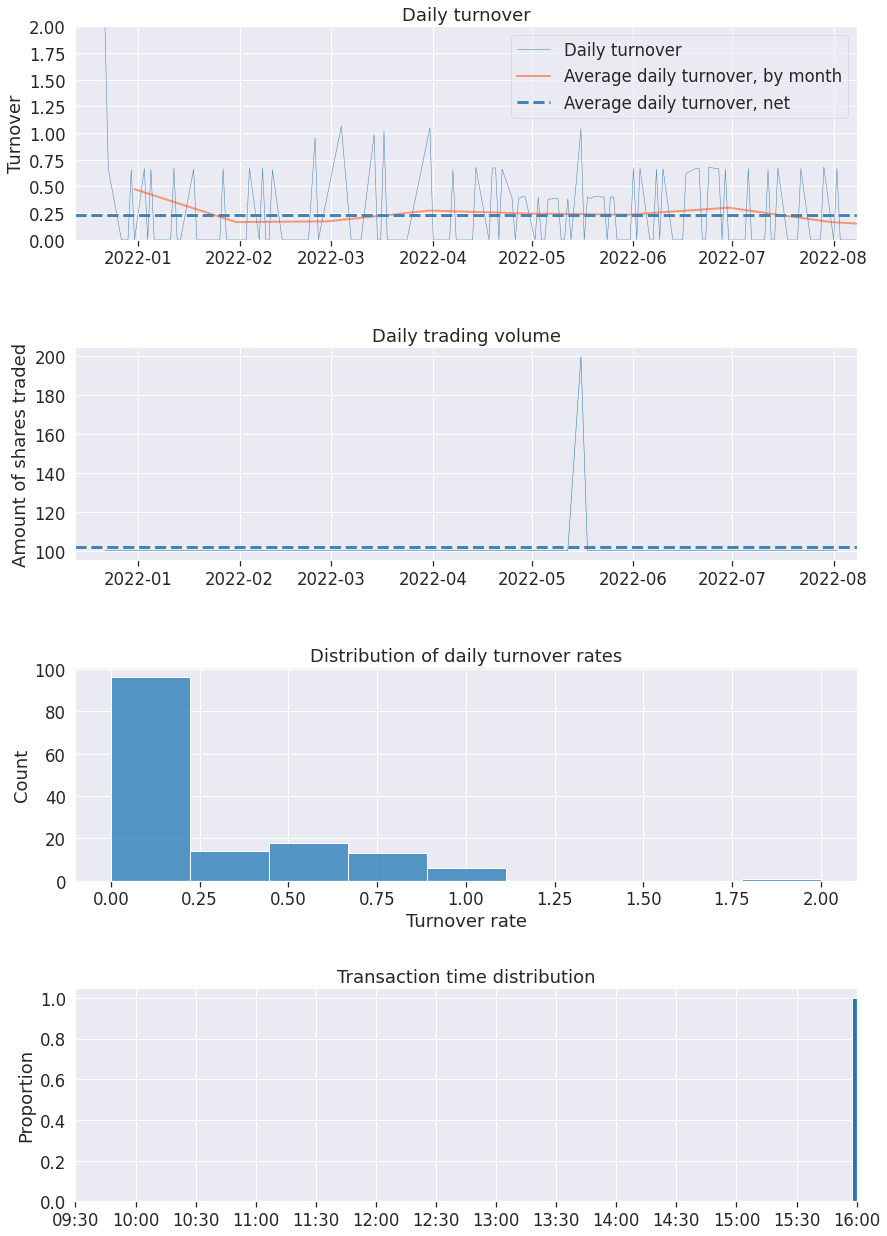

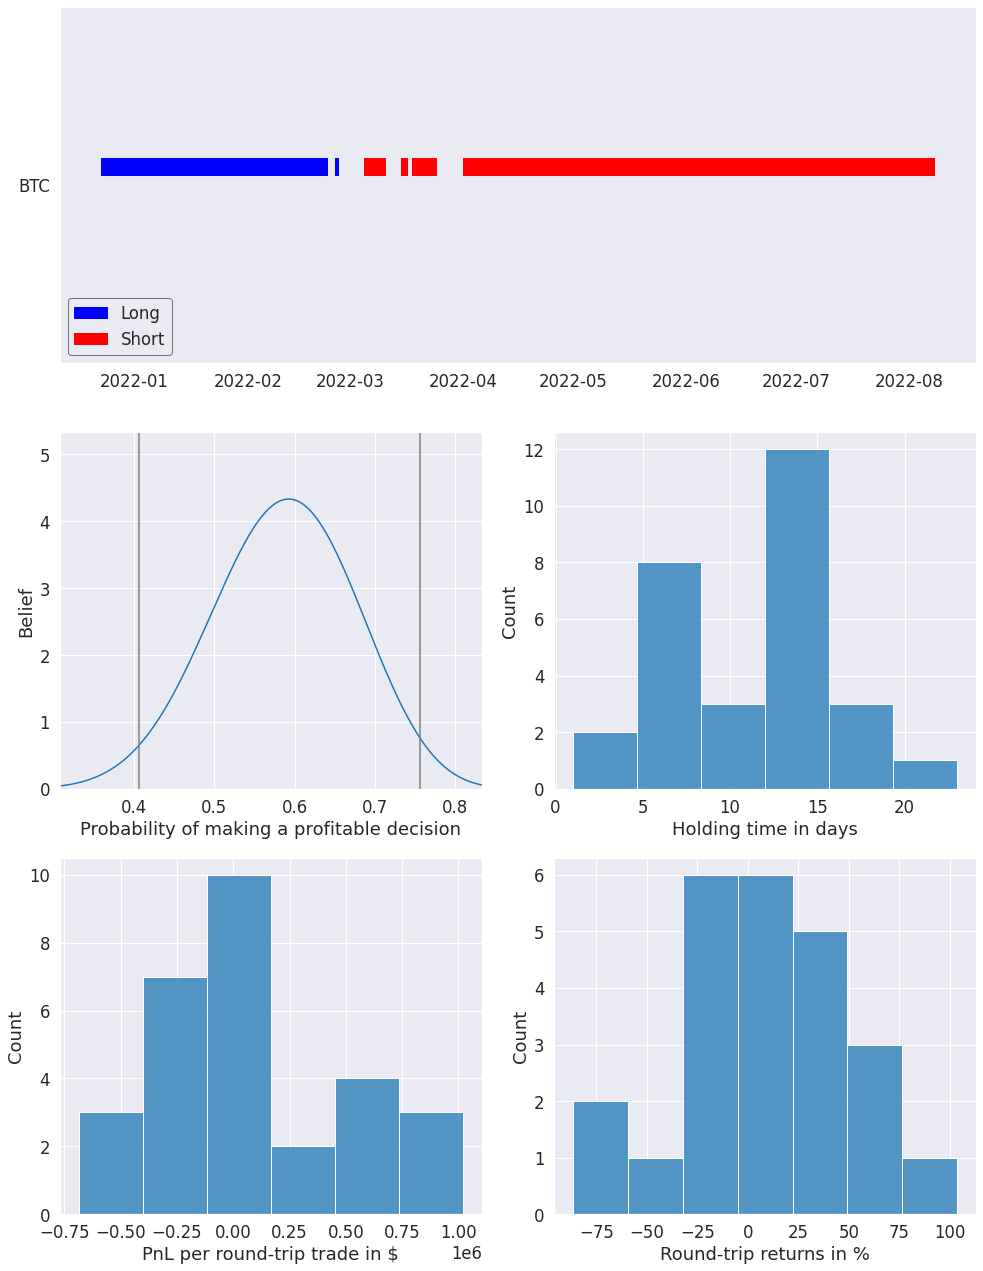

In [10]:
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions, round_trips=True)